# Patch Healnet Quadrant Model

### Healing Stages
* `Hemostasis:`  Initial injury or wound debrided (damaged tissue is removed using surgical instruments) during the past 48 hours. ***Indicator: Wound edges are sharp and obvious. Blood clots may be visible.***

* `Inflammatory:` Begins immediately after injury. Duration varies based on presence of infection. ***Indicator: Redness or swelling of the wound edge. Wet or shiny appearance of wound exudate (fluid that has seeped out of tissue). If infected, pus may be visible.***

* `Proliferative:` Tissue is rebuilt through granulation tissue and re-epithelialization. Wound size is reduced by contraction.. ***Indicator: Loss of shiny appearance as wound dries and exudate becomes granulation tissue. Wound edge and center texture may be uneven or variable. Re-epithelializaton forms new epithelium that may have pink coloring, distinguishing it from surrounding intact skin and granulation tissue in the center of the wound. New blood vessels (angiogenesis) may be visible. Overall reduction in wound size as wound contracts.***

* `Maturation:` Also called the remodeling stage of wound healing, tissue is reorganized and strengthened at a cellular level. ***Indicator: Healed with no open wound visible. Hair growth may be seen as skin appendages reform.***

#### References
* Shi, et al. (2015). Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. Retrieved December 11th, 2020, from the arXiv database
* S.M. Ali Eslami, et al. (2016). Attend, Infer, Repeat: Fast Scene Understanding with Generative Models. Retrieved Oct 20th, 2020, from the arXiv database
* Karol Gregor, et al. (2016). Towards Conceptual Compression. Retrieved Oct 20th, 2020, from the arXiv database
* S.M. Ali Eslami, et al. (2020). Representation Learning Without Labels ICML 2020
* H. Carrión et al. (2020). Automatic Wound Detection and Size Estimation using Deep Learning Algorithms. Retrieved November 2020 from the biorXiv databse
* Maity et al. Advanced Computational and Communication Paradigms. 2020
* Hinton et al. Science. 2006; 313
* Chino et al. Computer Methods and Programs in Biomedicine. 2020

In [1]:
# Load the Drive helper and mount:
from google.colab import drive

# This will prompt for authorization:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# sets the path to your working directory
%cd drive/MyDrive/BETR_Summer23

/content/drive/MyDrive/BETR_Summer23


In [60]:
# copy data
!cp data/exp_ctl_sep2_3x4_quad_train_classification.npy  /./content/exp_ctl_sep2_3x4_quad_train_classification.npy
!cp data/exp_ctl_sep2_3x4_quad_test_classification.npy  /./content/exp_ctl_sep2_3x4_quad_test_classification.npy
!cp "Saved Weights"/temporal_encoder_Michael_Nov5_GaussianBlur.h5 /content/temporal_encoder_Michael_Nov5_GaussianBlur.h5


In [ ]:
!ls /./content/

 exp_ctl_sep2_3x4_quad_test_classification.npy
 exp_ctl_sep2_3x4_quad_train_classification.npy
 HealNet_device_nov_6.h5
 logs
 sample_data
'Temporal Encoder DenseNet (Blanced Patch) Accuracy.pdf'
'Temporal Encoder DenseNet (Blanced Patch) Loss.pdf'
 temporal_encoder_Michael_Nov5_GaussianBlur.h5


In [ ]:
# Run this cell to revert to tf 2.10.0
# Restart runtime once the installs have finished

!pip uninstall tensorflow -y

print(f"\n installing tensorflow 2.10.0")
!pip install tensorflow==2.10.0

print(f"uninstalling keras-cv")
!pip uninstall keras-cv -y
print(f"installing keras-cv 0.2.10")
!pip install keras-cv==0.2.10

from google.colab import drive
drive.flush_and_unmount()


Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0

 installing tensorflow 2.10.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 61.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorflow-estimator
   

uninstalling keras-cv
installing keras-cv 0.2.10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
# you'll need to clone this once
# !git clone https://github.com/gabrielibagon/TensorBlur.git

In [3]:
!pip install tensorflow_addons
!pip install --upgrade gupload

import numpy as np
import math
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses
from keras.layers import TimeDistributed, Conv2D, Conv2DTranspose, ConvLSTM2D, LSTM, Concatenate
from keras.layers import MaxPool2D, Input, Dense, Reshape, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomContrast, Layer
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121, DenseNet169, Xception, \
    InceptionV3, NASNetMobile, MobileNetV3Small, ResNet50, MobileNet, VGG16
from keras.layers import Activation, Add, BatchNormalization, Concatenate, \
    Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape, \
    GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import pyplot as plt
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
import os
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from matplotlib.transforms import Bbox
from PIL import Image, ImageDraw
from copy import deepcopy
from scipy.ndimage import gaussian_filter
import cv2
from skimage import color as skcolor
from skimage import filters as skfilters
import glob
from copy import deepcopy
print(tf.__version__)
%matplotlib inline
%load_ext tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which 

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.14.0


## Dataset

### Create Device Patch Dataset

#### Create Train

In [ ]:
#!ls /content/drive/MyDrive/BETR_Summer23/data/train_ctl_sep2_3x4_quad

In [ ]:
from copy import deepcopy
# load patch train images
base_ = '/content/drive/MyDrive/BETR_Summer23/data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/'
imgs_quad = glob.glob(base_+'*.jpg')

#Create dataframe from images
count = 0
data =  pd.DataFrame(columns=["image","wound","day","quadrant"])
for fn in imgs_quad:
    tmp = fn.split("/")[-1].split("_")
    wound = "".join([tmp[1], tmp[3]]) # Exp-wound combined
    day = tmp[5]
    quad = tmp[7]
    data.loc[len(data.index)] = [fn, wound, day, quad]
    count += 1

print(f"created dataframe of size {data.shape}...")

nump_sample = 10
train_samples = []
train_label = []
count = 0

print("creating training samples...")

#Create training set
for quadrant in ["00", "01","10","11"]:
    for wound in data['wound'].unique():
        #select data from frame by wound and quadrant
        img_sample_df = data[ (data["quadrant"]==quadrant) & (data["wound"]==wound) ].groupby('day').apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True)).reset_index(drop=True)
        img_arr = np.array(img_sample_df["image"])
        img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
        #get days
        x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)

        # make day combos
        combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        drops = []
        for i in range(len(combos)):
            if combos[i][0] == combos[i][1]:
                drops.append(i)
            #elif abs(combos[i][0]-combos[i][1]) < 2:
            #    print(combos[i][0], combos[i][1], combos[i][0]-combos[i][1])
            #    drops.append(i)
        combos = np.delete(combos,drops,axis=0)

        #create image combo paths
        for i in range(nump_sample):
            for j in range(i+1, nump_sample):
                for combo in combos:
                    img_1 = (img_arr[combo[0], i])
                    img_2 = (img_arr[combo[1], j])
                    train_samples.append((img_1,img_2))
                    train_label.append(1 if combo[0] > combo[1] else 0)
                    count += 1

#load image combos into numpy arrays
x_train = np.ndarray((count, 2, 128, 128, 3), dtype=np.float32)
y_train = np.array(train_label, dtype=np.int32)
idx = 0

print(f"creating {len(train_samples)} pairs...")
for left_path, right_path in tqdm(train_samples):
    x_train[idx,0,:,:,:] = deepcopy(img_to_array( Image.open(left_path).resize((128,128)) ))
    x_train[idx,1,:,:,:] = deepcopy(img_to_array( Image.open(right_path).resize((128,128)) ))
    idx += 1


print(f" {len(train_samples)} sample pairs created.")



created dataframe of size (39255, 4)...
creating training samples...
creating 41760 pairs...


  0%|          | 0/41760 [00:00<?, ?it/s]

 41760 sample pairs created.


In [ ]:
!pwd

/content


In [ ]:
# Save patch images
# with open('data/exp_ctl_sep2_3x4_quad_train.npy', 'wb') as f:
#     np.save(f, train_samples)
#     np.save(f, x_train)
#     np.save(f, y_train)

#### Create Test set

In [ ]:
base_ = '/content/drive/MyDrive/BETR_Summer23/data/Sep2_cleaned_control_images_Patch_Image/test_ctl_sep2_3x4_quad/'
imgs_quad = glob.glob(base_+'*.jpg')

count = 0

data =  pd.DataFrame(columns=["image","wound","day","quadrant"])
for fn in imgs_quad:
    tmp = fn.split("/")[-1].split("_")
    #print(tmp)
    wound = "".join([tmp[1], tmp[3]]) # Exp-wound combined
    day = tmp[5]
    quad = tmp[7]
    #print(wound)
    data.loc[len(data.index)] = [fn, wound, day, quad]
    count += 1

print(f"created dataframe of size {data.shape}...")

nump_sample = 10
test_samples = []
test_label = []

count = 0

print("creating training samples...")
#Create training set
for quadrant in ["00", "01","10","11"]:
    for wound in data['wound'].unique():
        #select data from frame by wound and quadrant
        img_sample_df = data[ (data["quadrant"]==quadrant) & (data["wound"]==wound) ].groupby('day').apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True)).reset_index(drop=True)
        img_arr = np.array(img_sample_df["image"])
        img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
        #get days
        x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)

        # make day combos
        combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2) # make combos
        drops = []
        for i in range(len(combos)):
            if combos[i][0] == combos[i][1]:
                drops.append(i)
        combos = np.delete(combos,drops,axis=0)


        #create image combo paths
        for i in range(nump_sample):
            for j in range(i+1, nump_sample):
                for combo in combos:
                    img_1 = (img_arr[combo[0], i])
                    img_2 = (img_arr[combo[1], j])
                    test_samples.append((img_1,img_2))
                    test_label.append(1 if combo[0] > combo[1] else 0)
                    count += 1

#load image combos into numpy arrays
x_test = np.ndarray((count, 2, 128, 128, 3), dtype=np.float32)
y_test = np.array(test_label, dtype=np.int32)
idx = 0

print(f"creating {len(test_samples)} pairs...")
for left_path, right_path in tqdm(test_samples):
    x_test[idx,0,:,:,:] = deepcopy(img_to_array( Image.open(left_path).resize((128,128)) ))
    x_test[idx,1,:,:,:] = deepcopy(img_to_array( Image.open(right_path).resize((128,128)) ))
    idx += 1


print(f" {len(test_samples)} sample pairs created.")

created dataframe of size (8087, 4)...
creating training samples...
creating 13320 pairs...


  0%|          | 0/13320 [00:00<?, ?it/s]

 13320 sample pairs created.


In [ ]:
# Save patch images
with open('data/exp_ctl_sep2_3x4_quad_test.npy', 'wb') as f:
    np.save(f, test_samples)
    np.save(f, x_test)
    np.save(f, y_test)

### Full Image Temporal Encoder Dataset
closely resembles technique in the the paper. No Patches.

#### Train

In [ ]:
# Read in the images
base_train =  'data/Sep2_cleaned_control_images_Full_Image/train_ctl_sep2_3x4_cleaned/'
imgs_train = glob.glob(base_train+'*.jpg')

base_val = 'data/Sep2_cleaned_control_images_Full_Image/test_Exp_ctl_sep2_3x4_cleaned/'
imgs_val = glob.glob(base_val+'*.jpg')

In [ ]:
print( len(imgs_train), len(imgs_val) )

2459 509


In [ ]:
# Create one big list of images to give them labels
imgs_ = imgs_train + imgs_val
imgs_arr = np.array(imgs_)

In [ ]:
# Save Images
# with open('data/imgs_list.npy', 'wb') as f:
#    np.save(f, imgs_)
#    np.save(f, imgs_)

In [ ]:
# Load images
# with open('data/imgs_combined.npy', 'wb') as f:
#    np.save(f, imgs_)
#    np.save(f, imgs_arr)
# with open('data/imgs_combined.npy', 'rb') as f:
#    imgs_ = np.load(f)
#    imgs_arr = np.load(f)

In [ ]:
# Create dataframe
data =  pd.DataFrame(columns=["image","wound","day"])
for img in imgs_arr:
    tmp = img.split("/")[-1]
    tmp2 = tmp.split("_")
    wound_id = "".join([tmp2[1], tmp2[3]])
    day = int(tmp2[5])
    data.loc[len(data.index)] = [img, wound_id,day]

# New Section

In [ ]:
nump_sample = 8 # Change this to select the number of patches for each day
train_samples = []
train_label = []
count = 0

L_train_samples = []
R_train_samples = []

# Create image pairs for training images
for wound in [ '127', '123', '107', '103', '113', '117', '87', '83' ]: # REMOVED 13 FOR TEST
    img_sample_df = data[ (data["wound"]==wound) ].groupby('day',group_keys=False).apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True))
    img_arr = np.array( img_sample_df["image"].index )
    img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
    x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)
    combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    drops = []
    for i in range(len(combos)):
        if combos[i][0] == combos[i][1]:
            drops.append(i)
    combos = np.delete(combos,drops,axis=0)

    for i in range(nump_sample):
        for j in range(i+1, nump_sample):
            for combo in combos:
                L_train_samples.append(img_arr[combo[0], i])
                R_train_samples.append(img_arr[combo[1], j])

                train_label.append(1 if combo[0] > combo[1] else 0)
                count += 1
#Save to numpy arrays
x_train = deepcopy(np.stack((imgs_arr[L_train_samples],imgs_arr[R_train_samples])))
y_train = np.array(train_label, dtype=np.int32)

print(f"train data shape: {x_train.shape}, label shape: {y_train.shape}")

############################### TEST ###############################

L_test_samples = []
R_test_samples = []
test_samples = []
test_label = []

# Create image pairs for training images
for wound in  ['136', '135', '131', '132']: #  13 FOR TEST
    img_sample_df = data[ (data["wound"]==wound) ].groupby('day',group_keys=False).apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True))
    img_arr = np.array( img_sample_df["image"].index )
    img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
    x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)
    combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    drops = []
    for i in range(len(combos)):
        if combos[i][0] == combos[i][1]:
            drops.append(i)
    combos = np.delete(combos,drops,axis=0)

    for i in range(nump_sample):
        for j in range(i+1, nump_sample):
            for combo in combos:
                L_test_samples.append(img_arr[combo[0], i])
                R_test_samples.append(img_arr[combo[1], j])
                test_label.append(1 if combo[0] > combo[1] else 0)
                count += 1
#Save to numpy arrays
x_test = deepcopy(np.stack((imgs_arr[L_test_samples],imgs_arr[R_test_samples]),axis=1))
y_test = np.array(test_label, dtype=np.int32)

print(f"train data shape: {x_test.shape}, label shape: {y_train.shape}")

train data shape: (2, 6496), label shape: (6496,)
train data shape: (2072, 2), label shape: (6496,)


#### Load full image train and test data

In [ ]:
!ls data

 abMIL_12_Train_sep2_cleaned	  'near_quad_tr=0.5'
 abMIL_12_val_sep2_cleaned	   patch_healnet_arrays
 exp13_ctl_sep2			  'Pig_Labels_Cleaned_FINALESTFINALLLL (1).gsheet'
 exp_ctl_sep2_3x4_quad_train.npy   Pig_Labels_Cleaned_FINALESTFINALLLL.csv
 exp_ctl_sep2_test.npy		   Pig_Labels_Cleaned_FINALESTFINALLLL.gsheet
 exp_ctl_sep2_train.npy		   Sep2_cleaned_control_images_Full_Image
 iphone_train			   Sep2_cleaned_control_images_Patch_Image
 iphone_val			   train_ctl_sep2
 near				  'Wound Photos by iPhone'


In [ ]:
# Save x-test y-test, x-train,y-train
# Save Images
# with open('data/Positive_Negative_Pair_Dataset_Train.npy', 'wb') as f:
#    np.save(f, x_train)
#    np.save(f, y-train)

# with open('data/Positive_Negative_Pair_Dataset_Test.npy', 'wb') as f:
#    np.save(f, x_test)
#    np.save(f, y-test)

# Patch Load images
with open('data/exp_ctl_sep2_3x4_quad_test.npy', 'rb') as f:
    _ = np.load(f)
    x_test = np.load(f)
    y_test = np.load(f)



print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(41760, 2, 128, 128, 3) (13320, 2, 128, 128, 3)
(41760,) (13320,)


In [ ]:
def augment(images):
    images = RandomFlip("horizontal_and_vertical")(images)
    images = RandomRotation(0.5, fill_mode='constant')(images)
    images = RandomContrast(0.5)(images)
    #images = RandomColorDistortion()(images)
    image = GaussianBlur(kernel_size=(3, 3), sigma=(0, 2))(images)
    return images

#print(f" {count} samples created.")

# Augmentation

In [ ]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5],
                 brightness_delta=[-0.1, 0.1],
                 saturation_range=[0, 0.5],
                 hue_max_delta=0.001,
                 blur=0.5, **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
        self.min_sat, self.max_sat = saturation_range
        self.hue_max = hue_max_delta
        self.blur_sigma = blur

    def call(self, images, training=None):
        if not training:
            return images

        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])

        #images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.image.random_saturation(images, self.min_sat, self.max_sat)
        images = tf.image.random_hue(images, self.hue_max)
        images = tfa.image.gaussian_filter2d(images, self.blur_sigma)

        images = tf.clip_by_value(images, 0, 1)
        return images

In [ ]:
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images

In [ ]:
class GaussianBlur( tf.keras.__internal__.layers.BaseImageAugmentationLayer ):
    """Applies a Gaussian Blur with random sigma to an image.
    Args:
        kernel_size: int, 2 element tuple or 2 element list. x and y dimensions for
            the kernel used. If tuple or list, first element is used for the x dimension
            and second element is used for y dimension. If int, kernel will be squared.
        sigma: float, 2 element tuple or 2 element list. Interval in which sigma should
            be sampled from. If float, interval is going to be [0, float), else the
            first element represents the lower bound and the second element the upper
            bound of the sampling interval.
    """

    def __init__(self, kernel_size, sigma, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma = sigma

        if isinstance(kernel_size, (tuple, list)):
            self.x = kernel_size[0]
            self.y = kernel_size[1]
        else:
            if isinstance(kernel_size, int):
                self.x = self.y = kernel_size
            else:
                raise ValueError(
                    "`kernel_size` must be list, tuple or integer "
                    ", got {} ".format(type(self.kernel_size))
                )

        if isinstance(sigma, (tuple, list)):
            self.sigma_min = sigma[0]
            self.sigma_max = sigma[1]
        else:
            self.sigma_min = type(sigma)(0)
            self.sigma_max = sigma

        if not isinstance(self.sigma_min, type(self.sigma_max)):
            raise ValueError(
                "`sigma` must have lower bound and upper bound "
                "with same type, got {} and {}".format(
                    type(self.sigma_min), type(self.sigma_max)
                )
            )

        if self.sigma_max < self.sigma_min:
            raise ValueError(
                "`sigma` cannot have upper bound less than "
                "lower bound, got {}".format(sigma)
            )

        self._sigma_is_float = isinstance(self.sigma, float)
        if self._sigma_is_float:
            if not self.sigma_min >= 0.0:
                raise ValueError(
                    "`sigma` must be higher than 0"
                    "when is float, got {}".format(sigma)
                )

    def get_random_transformation(self, image=None, label=None, bounding_box=None):
        sigma = self.get_sigma()
        blur_v = GaussianBlur.get_kernel(sigma, self.y)
        blur_h = GaussianBlur.get_kernel(sigma, self.x)
        blur_v = tf.reshape(blur_v, [self.y, 1, 1, 1])
        blur_h = tf.reshape(blur_h, [1, self.x, 1, 1])
        return (blur_v, blur_h)

    def get_sigma(self):
        sigma = self._random_generator.random_uniform(
            shape=(), minval=self.sigma_min, maxval=self.sigma_max
        )
        return sigma

    def augment_image(self, image, transformation=None):

        image = tf.expand_dims(image, axis=0)

        num_channels = tf.shape(image)[-1]
        blur_v, blur_h = transformation
        blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
        blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
        blurred = tf.nn.depthwise_conv2d(
            image, blur_h, strides=[1, 1, 1, 1], padding="SAME"
        )
        blurred = tf.nn.depthwise_conv2d(
            blurred, blur_v, strides=[1, 1, 1, 1], padding="SAME"
        )

        return tf.squeeze(blurred, axis=0)

    @staticmethod
    def get_kernel(sigma, filter_size):
        x = tf.cast(
            tf.range(-filter_size // 2 + 1, filter_size // 2 + 1), dtype=tf.float32
        )
        blur_filter = tf.exp(
            -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, dtype=tf.float32), 2.0))
        )
        blur_filter /= tf.reduce_sum(blur_filter)
        return blur_filter

    def get_config(self):
        config = super().get_config()
        config.update({"sigma": self.sigma, "kernel_size": self.kernel_size})
        return config

## Temporal Encoder Davinci

## Create Davinci Train

In [ ]:
pigs_train = ["1323", "1326", "1327", "1328"]
wounds = ["Wound_A", "Wound_B", "Wound_C", "Wound_D", "Wound_E", "Wound_F",
          "Wound_G", "Wound_H", "Wound_I", "Wound_J", "Wound_K", "Wound_L"]

In [ ]:
from copy import deepcopy
# load patch train images
base_ = ''
imgs_quad = glob.glob("data/near_quad_tr=0.5/**/*.jpg",recursive=True)
data =  pd.DataFrame(columns=["image","wound","day","quadrant"])
for fn in imgs_quad:
    tmp = fn.split("/")
    img = fn
    day = tmp[2].split("_")[1]
    #print(tmp, day)
    img_id = tmp[3].split("_")
    #print(img_id)
    img_id = "_".join([img_id[2], img_id[3], img_id[4]])
    quadrant = img.split("_")[-2]
    #print(img_id,day, quadrant, img)
    data.loc[len(data.index)] = [img, img_id, day, quadrant]

test_data = data[data['wound'].str.contains("1324")].reset_index(drop=True)
train_data = data[~data['wound'].str.contains("1324")].reset_index(drop=True)


In [ ]:
train_samples = []
train_label = []
count = 0
wounds = data['wound'].unique()
nump_sample = 3

for quadrant in ["00", "01","10","11"]:
    for wound in wounds:
        img_sample_df = train_data[ (train_data["quadrant"]==quadrant) & (train_data["wound"]==wound) ].groupby('day',group_keys=False).apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True)).reset_index(drop=True)

        img_arr = np.array(img_sample_df["image"])
        img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
        x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)
        combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        drops = []

        for i in range(len(combos)):
            if combos[i][0] == combos[i][1]:
                drops.append(i)
        combos = np.delete(combos,drops,axis=0)
        for i in range(nump_sample):
            for j in range(i+1, nump_sample):
                for combo in combos:
                    img_1 = (img_arr[combo[0], i])
                    img_2 = (img_arr[combo[1], j])
                    train_samples.append((img_1,img_2))
                    train_label.append(1 if combo[0] > combo[1] else 0)
                    #print(img_1)
                    #print(img_2)
                    #print(label)
                    #print("")
                    count += 1

x_train =np.ndarray((count, 2, 128, 128, 3), dtype=np.float32)

y_train = np.array(train_label, dtype=np.int32)
idx = 0

for left_path, right_path in tqdm(train_samples):
    #im_l =
    #im_2 =
    x_train[idx,0,:,:,:] = img_to_array( Image.open(left_path) )
    x_train[idx,1,:,:,:] = img_to_array( Image.open(right_path) )
    idx += 1

print(f" {count} samples created.")


test_samples = []
test_label = []
count = 0
wounds = data['wound'].unique()
nump_sample = 3

for quadrant in ["00", "01","10","11"]:
    for wound in wounds:
        img_sample_df = test_data[ (test_data["quadrant"]==quadrant) & (test_data["wound"]==wound) ].groupby('day',group_keys=False).apply(lambda x:  x.sample(nump_sample,replace=False) if len(x) > nump_sample else x.sample(nump_sample,replace=True)).reset_index(drop=True)

        img_arr = np.array(img_sample_df["image"])
        img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
        x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)
        combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        drops = []

        for i in range(len(combos)):
            if combos[i][0] == combos[i][1]:
                drops.append(i)
        combos = np.delete(combos,drops,axis=0)
        for i in range(nump_sample):
            for j in range(i+1, nump_sample):
                for combo in combos:
                    img_1 = (img_arr[combo[0], i])
                    img_2 = (img_arr[combo[1], j])
                    test_samples.append((img_1,img_2))
                    test_label.append(1 if combo[0] > combo[1] else 0)
                    #print(img_1)
                    #print(img_2)
                    #print(label)
                    #print("")
                    count += 1

x_test =np.ndarray((count, 2, 128, 128, 3), dtype=np.float32)
y_test = np.array(test_label, dtype=np.int32)
idx = 0

for left_path, right_path in tqdm(test_samples):
    #im_l =
    #im_2 =
    x_test[idx,0,:,:,:] = img_to_array( Image.open(left_path) )
    x_test[idx,1,:,:,:] = img_to_array( Image.open(right_path) )
    idx += 1

print(f" {count} samples created.")


  0%|          | 0/14172 [00:00<?, ?it/s]

 14172 samples created.


  0%|          | 0/2856 [00:00<?, ?it/s]

 2856 samples created.


In [ ]:
idx = 0
for left_path, right_path in tqdm(test_samples):
    #im_l =
    #im_2 =
    x_test[idx,0,:,:,:] = deepcopy(img_to_array( Image.open(left_path).resize((128,128)) ))
    x_test[idx,1,:,:,:] = deepcopy(img_to_array( Image.open(right_path).resize((128,128)) ))
    idx += 1

print(f" {count} samples created.")

  0%|          | 0/2856 [00:00<?, ?it/s]

 2856 samples created.


In [ ]:
#with open('data/patch_train.npy', 'wb') as f:
#    np.save(f, x_train)
#    np.save(f, y_train)

#with open('data/patch_test.npy', 'wb') as f:
#    np.save(f, x_test)
#    np.save(f, y_test)

In [ ]:
with open('data/patch_train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)

with open('data/patch_test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f)

# Temporal Encoder

In [ ]:
in_shape = (128, 128, 3)
latent_size = 16

In [ ]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape = in_shape
)

In [ ]:
# This actually happens second than below
x = base_model.output
x = GlobalMaxPooling2D()(x) # should we do average pooling?
x = Dropout(0.5)(x) # should experiment with this
x = Dense(latent_size)(x)

feature_extractor = Model(inputs=base_model.input, outputs=x)

In [ ]:
stddev = 0.1

# good cell to remember when getting funky with layers (augmentation)
img_a = Input(shape=in_shape)
img_b = Input(shape=in_shape)

x_a = RandomFlip("horizontal_and_vertical")(img_a)
x_a = RandomRotation(0.5, fill_mode='constant')(x_a)
x_a = tf.keras.layers.GaussianNoise(stddev)(x_a)
x_a = RandomContrast(0.5)(x_a)
x_a = GaussianBlur(kernel_size=(3, 3), sigma=(0, 2))(x_a)
#x_a = RandomColorDistortion()(x_a)

x_b = RandomFlip("horizontal_and_vertical")(img_b)
x_b = RandomRotation(0.5, fill_mode='constant')(x_b)
x_b = tf.keras.layers.GaussianNoise(stddev)(x_b)
x_b = RandomContrast(0.5)(x_b)
x_b = GaussianBlur(kernel_size=(3, 3), sigma=(0, 2))(x_b)
#x_b = RandomColorDistortion()(x_b)

x_a = densenet_preprocess(x_a)
x_b = densenet_preprocess(x_b)

features_a = feature_extractor(x_a)
features_b = feature_extractor(x_b)

concat = Concatenate()([features_a, features_b])

output = Dense(1, activation="sigmoid")(concat)
temporal_encoder = Model(inputs=[img_a, img_b], outputs=output)

In [ ]:
temporal_encoder.compile(loss="binary_crossentropy",
                         optimizer=Adam(0.00075),
                         metrics=['accuracy'])


In [ ]:
best_model_file = "./Saved Weights/HealNet_encoder_Michael_Nov5_GaussianBlur.h5"

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor = 0.1,
                              patience = 6,
                              min_lr = 0.000001,
                              verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = f'./logs/HealNet_encoder_device_patches',
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)


best_model = ModelCheckpoint(best_model_file,
                             monitor = 'val_accuracy',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

callback_list = [reduce_lr, earlystop, best_model, tensor_board]

In [ ]:
history_densenet = temporal_encoder.fit(
    x = [x_train[:,0], x_train[:,1]],
    y = y_train,
    validation_data = (([x_test[:,0], x_test[:,1]]), y_test),
    batch_size = 32,
    epochs = 20,
    verbose = 1,
    callbacks = callback_list
)

Epoch 1/20


1305/1305 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.6495
Epoch 1: val_accuracy improved from -inf to 0.65270, saving model to ./Saved Weights/HealNet_encoder_Michael_Nov5_GaussianBlur.h5
1305/1305 [==============================] - 489s 347ms/step - loss: 0.8360 - accuracy: 0.6495 - val_loss: 0.5925 - val_accuracy: 0.6527 - lr: 7.5000e-04
Epoch 2/20
1305/1305 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7216
Epoch 2: val_accuracy improved from 0.65270 to 0.68709, saving model to ./Saved Weights/HealNet_encoder_Michael_Nov5_GaussianBlur.h5
1305/1305 [==============================] - 438s 336ms/step - loss: 0.5735 - accuracy: 0.7216 - val_loss: 0.6076 - val_accuracy: 0.6871 - lr: 7.5000e-04
Epoch 3/20
1305/1305 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7507
Epoch 3: val_accuracy did not improve from 0.68709
1305/1305 [==============================] - 436s 334ms/step - loss: 0.5081 - accuracy: 0.7507 

In [ ]:
history_densenet

In [ ]:
# Save the weights
feature_extractor.save_weights('./Saved Weights/temporal_encoder_Michael_Nov5_GaussianBlur.h5')

In [ ]:
base_model.save_weights('./Saved Weights/base_model_Michael_Nov5_GaussianBlur.h5')

In [ ]:
#best_model_file = "cHealNet_encoder_davinci_patches_quadrant.h5"
#model = keras.models.load_model(best_model_file)

## Get Embeddings

In [ ]:
"""
# Get embeddings?
image_fns = glob.glob( "data/near_quad_tr=0.5/**/*.jpg" , recursive=True)
#print(direc + "**/*.jpg" )
#ratio = 1.0/255.0
imgs_ = np.ndarray((len(image_fns), 128, 128, 3), dtype=np.float32)
embeddings = np.ndarray((len(image_fns), 16), dtype=np.float32)
idx = 0
for fn in tqdm(image_fns):
    imgs_[idx,:,:,:] = img_to_array( Image.open(fn) )
"""

KeyboardInterrupt: ignored

In [ ]:
def get_feature_vectors(model, direc=''):
    features = []
    img_names = []
    image_fns = glob.glob( direc + "**/*.jpg" , recursive=True)
    print(len(image_fns))
    #print(direc + "**/*.jpg" )
    #ratio = 1.0/255.0
    for i in tqdm(image_fns):
        #fn =  i
        loaded_image = load_img(i).resize((128,128))
        image_data = img_to_array(loaded_image)
        loaded_image.close()
        #print(image_data.shape)
        #image_data =  # densenet hardcoded!
        #image_data = np.expand_dims(densenet_preprocess(image_data), axis=0) # adds batch dim
        feat = model.predict(np.expand_dims(densenet_preprocess(image_data), axis=0), verbose = 0).flatten()
        #feat = model(image_data, training=False).numpy()
        #print(feat.shape)
        #feat = feat.flatten()
        features.append(feat)
        img_names.append(i)

    return features, img_names

In [ ]:
!tar cf - data/Sep2_cleaned_control_images_Patch_Image/ -P | pv -s $(du -sb data/Sep2_cleaned_control_images_Patch_Image/ | awk '{print $1}') | gzip > data/Sep2_cleaned_control_images_Patch_Image.tar.gz

^C


In [ ]:
!tar -zcvf data/Sep2_cleaned_control_images_Patch_Image.tar.gz data/Sep2_cleaned_control_images_Patch_Image/

Streaming output truncated to the last 5000 lines.
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_01_1.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_01_2.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_01_3.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_10_0.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_10_1.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_10_2.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_10_3.jpg
data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/Exp_10_Wound_7_Day_3_2023-03-02-08-02-59_11_0.j

In [ ]:
!gdown --no-cookies 1GMO3b5f0JhqI3n7-PF6IlZgQgFL8YPXl

Downloading...
From: https://drive.google.com/uc?id=1GMO3b5f0JhqI3n7-PF6IlZgQgFL8YPXl
To: /content/Sep2_cleaned_control_images_Patch_Image.tar.gz
100% 1.06G/1.06G [00:22<00:00, 46.4MB/s]


In [ ]:
! mkdir Sep2_cleaned_control_images_Patch_Image

test_ctl_sep2_3x4_quad/  train_ctl_sep2_3x4_quad/


In [ ]:
#!tar -xzf Sep2_cleaned_control_images_Patch_Image.tar.gz -C /content/Sep2_cleaned_control_images_Patch_Image

In [ ]:
from copy import deepcopy
# load patch train images
base_ = '/content/Sep2_cleaned_control_images_Patch_Image/data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/'
imgs_quad = glob.glob(base_+'*.jpg')

#Create dataframe from images
count = 0
data =  pd.DataFrame(columns=["image","wound","day","quadrant"])
for fn in imgs_quad:
    tmp = fn.split("/")[-1].split("_")
    wound = "".join([tmp[1], tmp[3]]) # Exp-wound combined
    day = tmp[5]
    quad = tmp[7]
    data.loc[len(data.index)] = [fn, wound, day, quad]
    count += 1

imgs_list = [x.split("/")[-1] for x in list(data['image'])]
print(f"created dataframe of size {data.shape}...")

#load image combos into numpy arrays
x_train = np.ndarray((count, 128, 128, 3), dtype=np.float32)
idx=0

print(f"creating training set patch array...")
for left_path in tqdm(data['image']):
    x_train[idx,:,:,:] = deepcopy(img_to_array( Image.open(left_path).resize((128,128)) ))
    idx += 1


print(f" {idx+1} sample created.")


created dataframe of size (39255, 4)...
creating training set patch array...


  0%|          | 0/39255 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
!ls data

 abMIL_12_Train_sep2_cleaned			  near
 abMIL_12_val_sep2_cleaned			 'near_quad_tr=0.5'
 exp13_ctl_sep2					  patch_healnet_arrays
 exp_ctl_sep2_3x4_quad_test_classification.npy	 'Pig_Labels_Cleaned_FINALESTFINALLLL (1).gsheet'
 exp_ctl_sep2_3x4_quad_test.npy			  Pig_Labels_Cleaned_FINALESTFINALLLL.csv
 exp_ctl_sep2_3x4_quad_train_classification.npy   Pig_Labels_Cleaned_FINALESTFINALLLL.gsheet
 exp_ctl_sep2_3x4_quad_train.npy		  Sep2_cleaned_control_images_Full_Image
 exp_ctl_sep2_test.npy				  Sep2_cleaned_control_images_Patch_Image
 exp_ctl_sep2_train.npy				  Sep2_cleaned_control_images_Patch_Image.tar.gz
 iphone_train					  train_ctl_sep2
 iphone_val					 'Wound Photos by iPhone'


In [ ]:
with open('data/exp_ctl_sep2_3x4_quad_train_classification.npy', 'wb') as f:
     np.save(f, imgs_list)
     np.save(f, x_train)

In [ ]:
from copy import deepcopy
# load patch train images
base_ = '/content/Sep2_cleaned_control_images_Patch_Image/data/Sep2_cleaned_control_images_Patch_Image/test_ctl_sep2_3x4_quad/'
imgs_quad = glob.glob(base_+'*.jpg')

#Create dataframe from images
count = 0
data =  pd.DataFrame(columns=["image","wound","day","quadrant"])
for fn in imgs_quad:
    tmp = fn.split("/")[-1].split("_")
    wound = "".join([tmp[1], tmp[3]]) # Exp-wound combined
    day = tmp[5]
    quad = tmp[7]
    data.loc[len(data.index)] = [fn, wound, day, quad]
    count += 1

imgs_list = [x.split("/")[-1] for x in list(data['image'])]
print(f"created dataframe of size {data.shape}...")

#load image combos into numpy arrays
x_train = np.ndarray((count, 128, 128, 3), dtype=np.float32)
idx=0

print(f"creating training set patch array...")
for left_path in tqdm(data['image']):
    x_train[idx,:,:,:] = deepcopy(img_to_array( Image.open(left_path).resize((128,128)) ))
    idx += 1


print(f" {idx+1} sample created.")

with open('data/exp_ctl_sep2_3x4_quad_test_classification.npy', 'wb') as f:
     np.save(f, imgs_list)
     np.save(f, x_train)

created dataframe of size (8087, 4)...
creating training set patch array...


  0%|          | 0/8087 [00:00<?, ?it/s]

 8088 sample created.


In [ ]:
feature_vectors, image_names = get_feature_vectors(feature_extractor, train_pth)

In [ ]:
#feature_vectors = np.array(feature_vectors )
#with open('data/davinci_feature_vectors.npy', 'wb') as f:
#    np.save(f, feature_vectors)
#    np.save(f, image_names)

# with open('data/davinci_feature_vectors.npy', 'rb') as f:
#    feature_vectors = np.load(f)
#    image_names = np.load(f)

In [ ]:
#imbeddings = pd.DataFrame(columns=["image","quadrant", "num", "embedding"])
#for img in tqdm(image_names):
#    img_only = img.split("/")[-1]
#    quadrant = img_only.split("_")[1]
#    num = img_only.split("_")[2].split(".")[0]
#    imbeddings.loc[len(imbeddings.index)] = [img_only, quadrant, num, feature_vectors[len(imbeddings.index)]]

  0%|          | 0/19539 [00:00<?, ?it/s]

In [ ]:
#imbeddings.to_csv("data/davinci_embeddings_quad.csv")

In [ ]:
#imbeddings = pd.read_csv("data/davinci_embeddings_quad.csv")

In [ ]:
"""
import re
img_name = []
embedding = []
for i in range( len( imbeddings["embedding"] ) ):
    if 0.0 in [float(x) for x in re.findall(r"[-+]?(?:\d*\.*\d+)", imbeddings["embedding"][i])]:
        print( re.findall(r"[-+]?(?:\d*\.*\d+)",imbeddings["embedding"][i]) )
        print(imbeddings["embedding"][i] )
    embedding.append( deepcopy( [ float(x) for x in re.findall(r"[-+]?(?:\d*\.*\d+)",imbeddings["embedding"][i]) ] ) )
    img_name.append(imbeddings['image'].loc[i])
    #print(np.fromstring( imbeddings["embedding"][i].strip(),sep="," ))
imbeddings['image'] = img_name
imbeddings["embedding"] = embedding
"""

'\nimport re\nimg_name = []\nembedding = []\nfor i in range( len( imbeddings["embedding"] ) ):\n    if 0.0 in [float(x) for x in re.findall(r"[-+]?(?:\\d*\\.*\\d+)", imbeddings["embedding"][i])]:\n        print( re.findall(r"[-+]?(?:\\d*\\.*\\d+)",imbeddings["embedding"][i]) )\n        print(imbeddings["embedding"][i] )\n    embedding.append( deepcopy( [ float(x) for x in re.findall(r"[-+]?(?:\\d*\\.*\\d+)",imbeddings["embedding"][i]) ] ) )\n    img_name.append(imbeddings[\'image\'].loc[i])\n    #print(np.fromstring( imbeddings["embedding"][i].strip(),sep="," ))\n'

#### Patch Classification

In [ ]:
# The code I used to combine the 16-dim latents
# Don't need for now, this is quadrant model combination classification
combined_idx = 0
combined_dict = {}
for i in range(len(imbeddings)):
    img_orig = imbeddings.loc[i]["image"]
    img_orig = img_orig.split("_")[0]+".jpg"
    quad = imbeddings.loc[i]["quadrant"]
    if img_orig not in combined_dict.keys():
        combined_dict[img_orig] = {}
    if quad not in combined_dict[img_orig].keys():
        combined_dict[img_orig][quad] = deepcopy(imbeddings.loc[i]['embedding'])
        #print(len(combined_dict[img_orig][quad]))
    else:
        #print(len(combined_dict[img_orig][quad]))
        #print(type(imbeddings.loc[i]['embedding']) )
        c = np.concatenate((combined_dict[img_orig][quad],imbeddings.loc[i]['embedding']))
        combined_dict[img_orig][quad] = deepcopy(c)
        #if img_orig == '3J6A1980.jpg':
        #    print(c)
        #combined_dict[img_orig][quad].extend(deepcopy(imbeddings.loc[i]['embedding'] ))

combined_final = {}
q0=q1=q2=q3=0
tmp = np.zeros((len(combined_dict.keys()), 16*12))
for i, img_ in enumerate(combined_dict.keys()):

    for quad in combined_dict[img_]:
        if len(combined_dict[img_][quad]) < 48:
            #print(len(combined_dict[img_][quad]))
            new = np.pad(combined_dict[img_][quad], (48-len(combined_dict[img_][quad]))//2)
        else:
            new = combined_dict[img_][quad]

        if quad == "00":
            tmp[i,0:48]= deepcopy(new)
            #q0 += 1
        elif quad == "01":
            tmp[i,48:96]= deepcopy(new)
            q1 += 1
        elif quad == "10":
            tmp[i,96:144]= deepcopy(new)
            q2 += 1
        elif quad == "11":
            tmp[i,144:192]= deepcopy(new)
            q2 += 1
    #combined_final[img_] = deepcopy(tmp)

In [ ]:
#combined_embeddings.to_csv('data/combined_embeddings.csv')

In [ ]:
folders = {}
for img in labels['image']:
    #if img.split(".")[0] == '3J6A3849':
    #    continue
    for fn in imgs_fn:
        if img in fn:
            folder = fn.split("/")[-2]
            if folder not in folders.keys():
                folders[folder] = labels['final_label'][labels['image'] == img].values[0]

In [ ]:
corrected_img = []
for img in imgs_fn:
    if '3J6A3849' not in img:
        corrected_img.append(img)

davinci_labels = []
for fn in corrected_img:
    folder = fn.split("/")[-2]
    davinci_labels.append(folders[folder])

In [ ]:
#davinci_embedding_data
# with open('data/davinci_embedding_data.npy', 'wb') as f:
#    np.save(f, np.array(corrected_img)) # original file structure: wound, day, etc
#    np.save(f, np.array(list(combined_dict.keys()))) # original image names
#    np.save(f, np.array(davinci_labels)) # labels for original images
#    np.save(f, tmp) # embeddings
with open('data/davinci_embedding_data.npy', 'rb') as f:
    corrected_img = np.load(f) # original file structure: wound, day, etc
    dict_keys = np.load(f) # original image names
    davinci_labels = np.load(f) # labels for original images
    tmp = np.load(f) # embeddings

In [ ]:
stage_ ={'Hemostasis':0, 'Inflammatory': 1, 'Proliferative':2, 'Maturation':3}

In [ ]:
test_index = []
train_index = []
for i,img in enumerate(corrected_img):
    if "1325" in img:
        test_index.append(i)
    else:
        train_index.append(i)

davinci_test_labels = np.array( [stage_[x] for x in np.array(davinci_labels)[test_index] ] )
davinci_test = tmp[test_index]

davinci_train_labels =  np.array( [ stage_[x] for x in np.array(davinci_labels)[train_index] ] )
davinci_train = tmp[train_index]

In [ ]:
# Embedding Classifier

In [ ]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.Normalization()
normalizer.adapt(davinci_train)

In [ ]:
inputs = keras.Input(shape=(192,))
x = normalizer(inputs)
#x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = Dropout(0.3)(x) # should experiment with this
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)
combined_embedding_model = keras.Model(inputs=inputs, outputs=outputs, name="combined_embedding_model")

In [ ]:
combined_embedding_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.000075), metrics=['accuracy'])

In [ ]:
best_model_file = "./Saved Weights/combined_embedding_model.h5"

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 250,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor = 0.1,
                              patience = 6,
                              min_lr = 0.000001,
                              verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = f'./logs/HealNet_encoder_device_patches',
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)


best_model = ModelCheckpoint(best_model_file,
                             monitor = 'val_accuracy',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

callback_list = [reduce_lr, earlystop, best_model, tensor_board]

In [ ]:
history_densenet = combined_embedding_model.fit(
    x = davinci_train,
    y = davinci_train_labels,
    validation_data = (davinci_test, davinci_test_labels),
    batch_size = 32,
    epochs = 5000,
    verbose = 1,
    #callbacks = callback_list
)

Streaming output truncated to the last 5000 lines.
43/43 [==============================] - 0s 3ms/step - loss: 0.8276 - accuracy: 0.6320 - val_loss: 1.5541 - val_accuracy: 0.3686
Epoch 2502/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8389 - accuracy: 0.6087 - val_loss: 1.5585 - val_accuracy: 0.3759
Epoch 2503/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8419 - accuracy: 0.6102 - val_loss: 1.5674 - val_accuracy: 0.3686
Epoch 2504/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8278 - accuracy: 0.6153 - val_loss: 1.5715 - val_accuracy: 0.3723
Epoch 2505/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8354 - accuracy: 0.6167 - val_loss: 1.5651 - val_accuracy: 0.3759
Epoch 2506/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8347 - accuracy: 0.6145 - val_loss: 1.5588 - val_accuracy: 0.3796
Epoch 2507/5000
43/43 [==============================] - 0s 3ms/step - loss: 0.8179 - accuracy:

# Classifier Device Images

In [ ]:
!ls /content/

exp_ctl_sep2_3x4_quad_test_classification.npy	sample_data
exp_ctl_sep2_3x4_quad_train_classification.npy	temporal_encoder_Michael_Nov5_GaussianBlur.h5


In [ ]:
!ls -lu /content/exp_ctl_sep2_3x4_quad_train_classification.npy

-rw-r--r-- 1 root root 83615 Nov  6 18:38 /content/exp_ctl_sep2_3x4_quad_train_classification.npy


In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

In [61]:
# Patch Load images
"""
import gdown
# upload train .npy from drive
id = "1-H8YQjO1-R7Hi0jITG3R3BVOWziORqYu"
output = "/content/exp_ctl_sep2_3x4_quad_train_classification.npy"
#id=id
url = "https://drive.google.com/uc?id=1-H8YQjO1-R7Hi0jITG3R3BVOWziORqYu"
gdown.download(url=url, output=output, quiet=False)

# upload train .npy from drive
id = "1-NlxvLPqYV3jrcqslEA9dyFh22Rn-JfQ"
output = "/content/exp_ctl_sep2_3x4_quad_test_classification.npy"
#id=id
url = "https://drive.google.com/uc?id=1-NlxvLPqYV3jrcqslEA9dyFh22Rn-JfQ"
gdown.download(url=url, output=output, quiet=False)
"""

#day to stage mapping
day_to_stage = {"0": 0, "1":1, "2":1, "3":2, "4":2, "5":2, "6":2}

with open('/content/exp_ctl_sep2_3x4_quad_train_classification.npy', 'rb') as f:
    train_names = np.load(f)
    x_train = np.load(f)
print(len(train_names), x_train.shape)

# Patch Load images
with open('/content/exp_ctl_sep2_3x4_quad_test_classification.npy', 'rb') as f:
    test_names = np.load(f)
    x_test = np.load(f)
print(len(test_names), x_test.shape)

#add labels train
labels_train = []
for x in train_names:
    tmp = x.split("/")[-1].split("_")[5]
    labels_train.append(day_to_stage[tmp])
labels_train = np.array(labels_train)

labels_val = []
for x in test_names:
    tmp = x.split("/")[-1].split("_")[5]
    labels_val.append(day_to_stage[tmp])
labels_val = np.array(labels_val)

39255 (39255, 128, 128, 3)
8087 (8087, 128, 128, 3)


In [ ]:
"""
#Load images (cleaned, no pairs)
imgs_train = glob.glob('/content/Sep2_cleaned_control_images_Patch_Image/data/Sep2_cleaned_control_images_Patch_Image/train_ctl_sep2_3x4_quad/*.jpg', recursive = True)
imgs_val = glob.glob('/content/Sep2_cleaned_control_images_Patch_Image/data/Sep2_cleaned_control_images_Patch_Image/test_ctl_sep2_3x4_quad/*.jpg', recursive = True)
print(len(imgs_train), len(imgs_val))

day_to_stage = {"0": 0, "1":1, "2":1, "3":2, "4":2, "5":2, "6":2}
# 0-value is hemostastis
# 1-value is inflam
# 2-value is prol
# 3-value would be maturation

#add labels train
labels_train = []
for x in imgs_train:
    tmp = x.split("/")[-1].split("_")[5]
    labels_train.append(day_to_stage[tmp])

labels_val = []
for x in imgs_val:
    tmp = x.split("/")[-1].split("_")[5]
    labels_val.append(day_to_stage[tmp])

train_df = pd.DataFrame(imgs_train, columns = ["image"])
train_df['cluster']=labels_train

val_df = pd.DataFrame(imgs_val, columns = ["image"])
val_df['cluster']=labels_val

img_dir = None
 # not doing any rescaling here as preprocess_input should deal with it
image_generator = ImageDataGenerator(

)
train_generator = image_generator.flow_from_dataframe(
    dataframe = train_df,
    #directory = img_dir,
    x_col = "image",
    y_col = "cluster",
    batch_size = 1024,
    shuffle = True,
    class_mode = "raw",
    target_size = (128, 128)
)

# Flow from directory with specified batch size and target image size
val_generator = image_generator.flow_from_dataframe(
    dataframe = val_df,
    #directory = img_dir,
    x_col = "image", # features
    y_col = "cluster", # labels
    class_mode = "raw", # 'Mass' column should be in train_df
    batch_size = 1024, # images per batch
    shuffle = False, # shuffle the rows or not
    target_size = (128, 128) # width and height of output image
)
print(len(train_generator), len(val_generator))
"""

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
# train_embeddings = feature_extractor.predict(x_train)

1227/1227 [==============================] - 24s 17ms/step


In [ ]:
# del train_embeddings

In [ ]:
"""
import numpy as np
from sklearn.manifold import TSNE
from sklearn import decomposition

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300);
tsne_results = tsne.fit_transform(train_embeddings);
df = pd.DataFrame(tsne_results,columns=['tsne-one', 'tsne-two'])
df['y'] = np.array(labels_train)
plt.figure(figsize=(16,10))
sns.scatterplot(
x="tsne-one", y="tsne-two",
hue="y",
palette=sns.color_palette("hls", 3),
data=df,
legend="full",
alpha=0.8
).set(title='t-sne Clustering w/ actual label')

pca = decomposition.PCA(n_components=2)
pca.fit(train_embeddings)
X_ = pca.transform(train_embeddings)

#Plot PCA clusters W real label
df = pd.DataFrame(X_,columns=['pca-one', 'pca-two'])
df['y'] = np.array(labels_train)
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.8
).set(title= f"pca Clustering w/ real labels" )
plt.show()
plt.close()
"""

'\nimport numpy as np\nfrom sklearn.manifold import TSNE\nfrom sklearn import decomposition\n\ntsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300);\ntsne_results = tsne.fit_transform(train_embeddings);\ndf = pd.DataFrame(tsne_results,columns=[\'tsne-one\', \'tsne-two\'])\ndf[\'y\'] = np.array(labels_train)\nplt.figure(figsize=(16,10))\nsns.scatterplot(\nx="tsne-one", y="tsne-two",\nhue="y",\npalette=sns.color_palette("hls", 3),\ndata=df,\nlegend="full",\nalpha=0.8\n).set(title=\'t-sne Clustering w/ actual label\')\n\npca = decomposition.PCA(n_components=2)\npca.fit(train_embeddings)\nX_ = pca.transform(train_embeddings)\n\n#Plot PCA clusters W real label\ndf = pd.DataFrame(X_,columns=[\'pca-one\', \'pca-two\'])\ndf[\'y\'] = np.array(labels_train)\nplt.figure(figsize=(10,10))\nsns.scatterplot(\n    x="pca-one", y="pca-two",\n    hue="y",\n    palette=sns.color_palette("hls", 4),\n    data=df,\n    legend="full",\n    alpha=0.8\n).set(title= f"pca Clustering w/ real labels"

In [ ]:
#train_embeddings
# Save patch images
#with open('data/exp_ctl_sep2_3x4_quad_train_embeddings.npy', 'wb') as f:
#    np.save(f, train_names)
#    np.save(f, train_embeddings)

In [ ]:
#test_embeddings = feature_extractor.predict(x_test)

253/253 [==============================] - 4s 16ms/step


In [ ]:
#del test_embeddings

In [ ]:
#train_embeddings
# Save patch images
#with open('data/exp_ctl_sep2_3x4_quad_test_embeddings.npy', 'wb') as f:
#    np.save(f, test_names)
#    np.save(f, test_embeddings)

In [ ]:
#dense_cls = keras.models.load_model("Saved Weights/Patch_HealNet_k4_corrected.h5")

In [ ]:
#base_model = keras.models.load_model("Saved Weights/HealNet_base_model_full_device_test=13_sep2.h5")

In [ ]:
in_shape = (128, 128, 3)
latent_size = 16

In [ ]:
#Initiate classifier models

# change this for output head PLEASE
base_model = DenseNet121(
     weights='imagenet',
     include_top=False,
     input_shape=in_shape)

# This actually happens second than below
x = base_model.output
x = GlobalMaxPooling2D()(x) # should we do average pooling?
x = Dropout(0.3)(x) # should experiment with this
x = Dense(latent_size)(x)

feature_extractor = Model(inputs=base_model.input, outputs=x)

feature_extractor.load_weights( '/content/temporal_encoder_Michael_Nov5_GaussianBlur.h5' ) # Feature extractor is the "image encoder"
feature_extractor.trainable = False

for layer in feature_extractor.layers:
    #print(layer.name, layer.trainable)
    if 'conv5' in layer.name:
        #print(layer.name)
        layer.trainable = True


for layer in feature_extractor.layers[-6:]:
    layer.trainable = True
#feature_extractor.layers[-5:].trainable = True

input = Input(shape=in_shape)
CLASSES = 3
x = RandomFlip("horizontal_and_vertical")(input)
x = RandomRotation(0.5, fill_mode='constant')(x)
x = RandomContrast(0.5)(x)

x = densenet_preprocess(x)

#x = base_model(x) # same model weights as before
x = feature_extractor(x)

# Need to find a way to combine all the 16-dim latents

x = Dense(16, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(CLASSES, activation="softmax")(x)

dense_cls = Model(inputs=input, outputs=x)


29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
# Load classifier weights
#dense_cls = keras.models.load_model('HealNet_device_nov_6.h5')

In [ ]:
dense_cls.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(0.0075), # small learning rate since we're transfer learning
                  metrics=['accuracy'])


In [ ]:
best_model_file = "HealNet_device_nov_6.h5"

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 25,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor = 0.5,
                              patience = 20,
                              min_lr = 0.0000001,
                              verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = './logs/Patch_HealNet_device_nov5',
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)

best_model = ModelCheckpoint(best_model_file,
                             monitor = 'val_accuracy',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

callback_list = [reduce_lr, earlystop, best_model, tensor_board]

In [ ]:
#dense_cls_history_ft = dense_cls.fit(
#    train_generator,
#    validation_data = val_generator,
#    epochs = 2500,
#    verbose = 1,
#    callbacks = callback_list)

#print( len(train_imgs), len(val_imgs), len(labels_train), len(labels_val) )
history_densenet = dense_cls.fit(
    x = x_train,
    y = labels_train,
    validation_data = (x_test, labels_val),
    batch_size = 64,
    epochs = 80,
    verbose = 1,
    callbacks = callback_list)



Epoch 1/80


614/614 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6482
Epoch 1: val_accuracy improved from -inf to 0.73068, saving model to HealNet_device_nov_6.h5
614/614 [==============================] - 282s 434ms/step - loss: 0.8233 - accuracy: 0.6482 - val_loss: 0.6933 - val_accuracy: 0.7307 - lr: 0.0075
Epoch 2/80
614/614 [==============================] - ETA: 0s - loss: 0.7987 - accuracy: 0.6572
Epoch 2: val_accuracy did not improve from 0.73068
614/614 [==============================] - 263s 429ms/step - loss: 0.7987 - accuracy: 0.6572 - val_loss: 0.7065 - val_accuracy: 0.7233 - lr: 0.0075
Epoch 3/80
614/614 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.6585
Epoch 3: val_accuracy did not improve from 0.73068
614/614 [==============================] - 263s 429ms/step - loss: 0.7958 - accuracy: 0.6585 - val_loss: 0.7066 - val_accuracy: 0.7268 - lr: 0.0075
Epoch 4/80
614/614 [==============================] - ETA: 0s - loss: 0.7965 - accur

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()

!gupload --to '1kbYAkP9BCT6lSo-oZ-HGLFMHpbfUGBSC' HealNet_device_nov_6.h5

Uploading file: HealNet_device_nov_6.h5


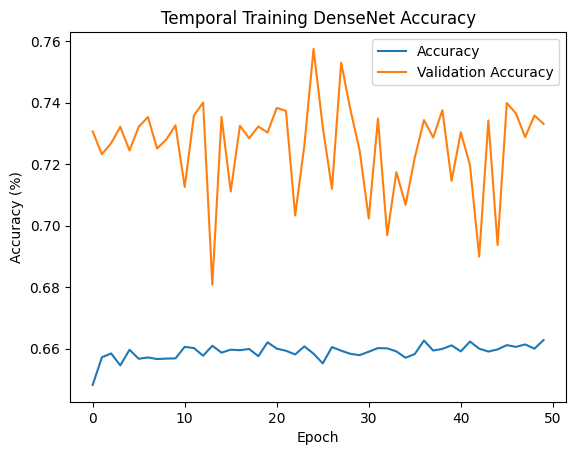

In [ ]:
val_acc = history_densenet.history['val_accuracy'][:]
acc = history_densenet.history['accuracy']

plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy (%)')
plt.title('Temporal Training DenseNet Accuracy')
plt.xlabel('Epoch')
plt.savefig('Temporal Encoder DenseNet (Blanced Patch) Accuracy.pdf')
plt.show()

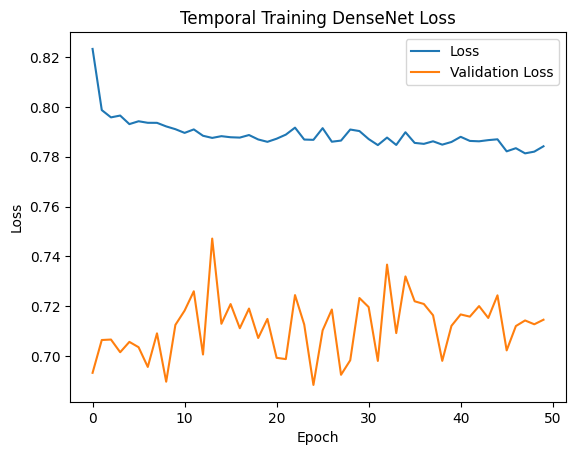

In [ ]:
val_acc = history_densenet.history['val_loss'][:]
acc = history_densenet.history['loss']

plt.plot(acc, label='Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.title('Temporal Training DenseNet Loss')
plt.xlabel('Epoch')
plt.savefig('Temporal Encoder DenseNet (Blanced Patch) Loss.pdf')
plt.show()

In [ ]:
x_train.shape

NameError: ignored

In [ ]:
del x_train

In [ ]:
del dense_cls

In [ ]:
train_preds = dense_cls.predict(x_train)

1227/1227 [==============================] - 27s 19ms/step


In [ ]:
test_preds = dense_cls.predict(x_test)

253/253 [==============================] - 6s 18ms/step


In [ ]:
train_preds.mean(0)

array([0.1153669 , 0.28497013, 0.5996627 ], dtype=float32)

In [ ]:
test_preds.mean(0)

array([0.09727612, 0.25003085, 0.6526932 ], dtype=float32)

In [ ]:
pred_df_train = pd.DataFrame(columns=['image', 'hemostasis','inflammation','proliferative'])
pred_df_train['image'] = train_names
pred_df_train['hemostasis'] = train_preds[:,0]
pred_df_train['inflammation'] = train_preds[:,1]
pred_df_train['proliferative'] = train_preds[:,2]

In [ ]:
!ls /content/

 device_image_prediction_scores_patch_ctlssep2_cleaned_nov6.csv
 device_image_test_prediction_scores_patch_ctlssep2_cleaned_nov6.csv
 exp_ctl_sep2_3x4_quad_test_classification.npy
 exp_ctl_sep2_3x4_quad_train_classification.npy
 HealNet_device_nov_6.h5
 logs
 sample_data
'Temporal Encoder DenseNet (Blanced Patch) Accuracy.pdf'
'Temporal Encoder DenseNet (Blanced Patch) Loss.pdf'
 temporal_encoder_Michael_Nov5_GaussianBlur.h5


In [ ]:
pred_df_train.to_csv("device_image_prediction_scores_patch_ctlssep2_cleaned_nov6.csv")

NameError: ignored

In [ ]:
pred_df_test = pd.DataFrame(columns=['image', 'hemostasis','inflammation','proliferative'])
pred_df_test['image'] = test_names
pred_df_test['hemostasis'] = test_preds[:,0]
pred_df_test['inflammation'] = test_preds[:,1]
pred_df_test['proliferative'] = test_preds[:,2]

NameError: ignored

In [ ]:
pred_df_test.to_csv("device_image_test_prediction_scores_patch_ctlssep2_cleaned_nov6.csv")

NameError: ignored

In [ ]:
test_loss, test_acc = dense_cls.evaluate(x=val_imgs, y=labels_val)

69/69 [==============================] - 4s 33ms/step - loss: 0.4218 - accuracy: 0.8547


In [ ]:
test_loss, test_acc = dense_cls.evaluate(x=train_imgs, y=labels_train)

24/24 [==============================] - 1s 35ms/step - loss: 0.4537 - accuracy: 0.8105


In [ ]:
!ls docs

 device_image_test_prediction_scores_patch_ctlssep2_cleaned_nov6.csv   'Healnet AB-MIL.gdoc'
 device_image_train_prediction_scores_patch_ctlssep2_cleaned_nov6.csv  'Healnet notes.gdoc'


In [4]:
pred_df_train = pd.read_csv("docs/device_image_train_prediction_scores_patch_ctlssep2_cleaned_nov6.csv")
pred_df_test = pd.read_csv("docs/device_image_test_prediction_scores_patch_ctlssep2_cleaned_nov6.csv")

In [88]:
main_img_train = {}

# Aggregate patch predictions by image
for x in pred_df_train['image']:
    tmp = "_".join(x.split("_")[:-2])+".jpg"
    if tmp  in main_img_train.keys():
        main_img_train[tmp].append( ( tmp, np.array( pred_df_train[ ['hemostasis','inflammation','proliferative' ] ][pred_df_train['image'] == x ].values[0] ) ) )
    else:
        main_img_train[tmp]= [  ( tmp, np.array( pred_df_train[ ['hemostasis','inflammation','proliferative' ] ][pred_df_train['image'] == x ].values[0] )  ) ]

# sort patch prediction
for img in main_img_train.keys():
    main_img_train[img].sort( key=lambda x: max(x[1]))

# get predictions
topk = 3
predictions = []
for img in main_img_train.keys():
    agg = np.zeros(3)
    for pred in main_img_train[img][:topk]:
        agg += pred[1]
        #print(pred)
    #print(agg, )
    predictions.append(np.argmax(agg))

#day to stage mapping
day_to_stage = {"0": 0, "1":1, "2":1, "3":2, "4":2, "5":2, "6":2}
train_labels_full = []
for img in main_img_train.keys():
    train_labels_full.append(day_to_stage[img.split("_")[5]])
train_labels_full = np.array(train_labels_full)

train_acc = np.sum(train_labels_full == predictions)/len(train_labels_full)
print(train_acc)

('Exp_12_Wound_7_Day_1_2023-05-17-14-51-11.jpg', array([0.14231339, 0.5727251 , 0.28496152]))
('Exp_12_Wound_7_Day_1_2023-05-17-14-51-11.jpg', array([0.18001592, 0.5709515 , 0.24903259]))
('Exp_12_Wound_7_Day_1_2023-05-17-14-51-11.jpg', array([0.17985821, 0.56931067, 0.25083122]))
[0.50218752 1.71298727 0.78482533] 1
0.6209841398942659


In [93]:
main_img_train = {}

# Aggregate patch predictions by image
for x in pred_df_test['image']:
    tmp = "_".join(x.split("_")[:-2])+".jpg"
    if tmp  in main_img_train.keys():
        main_img_train[tmp].append( ( tmp, np.array( pred_df_test[ ['hemostasis','inflammation','proliferative' ] ][pred_df_test['image'] == x ].values[0] ) ) )
    else:
        main_img_train[tmp]= [  ( tmp, np.array( pred_df_test[ ['hemostasis','inflammation','proliferative' ] ][pred_df_test['image'] == x ].values[0] )  ) ]

# sort patch prediction
for img in main_img_train.keys():
    main_img_train[img].sort( key=lambda x: max(x[1]))



0.7838899803536346


In [96]:
# get predictions
topk_list = [1,2,3,4,5,6,7,8,9,10,11,12]
for topk in topk_list:
    predictions = []
    for img in main_img_train.keys():
        agg = np.zeros(3)
        for pred in main_img_train[img][:topk]:
            agg += pred[1]
            #print(pred)
        #print(agg, )
        predictions.append(np.argmax(agg))

    #day to stage mapping
    day_to_stage = {"0": 0, "1":1, "2":1, "3":2, "4":2, "5":2, "6":2}
    train_labels_full = []
    for img in main_img_train.keys():
        train_labels_full.append(day_to_stage[img.split("_")[5]])
    train_labels_full = np.array(train_labels_full)

    train_acc = np.sum(train_labels_full == predictions)/len(train_labels_full)
    print("topk:", topk, "acc:", train_acc)

topk: 1 acc: 0.7111984282907662
topk: 2 acc: 0.7328094302554028
topk: 3 acc: 0.7799607072691552
topk: 4 acc: 0.7740667976424361
topk: 5 acc: 0.7838899803536346
topk: 6 acc: 0.7799607072691552
topk: 7 acc: 0.787819253438114
topk: 8 acc: 0.7897838899803536
topk: 9 acc: 0.7897838899803536
topk: 10 acc: 0.7897838899803536
topk: 11 acc: 0.7897838899803536
topk: 12 acc: 0.787819253438114


In [ ]:
# This disiplays the image by wound/xp by day
# pd.crosstab(index=data['wound'], columns=data['day'], margins=True)

day,0,1,2,3,4,5,6,All
wound,,,,,,,,
103,32,66,0,0,0,0,0,98
107,41,96,69,40,59,65,0,370
113,49,50,55,31,33,22,16,256
117,63,55,55,38,39,10,11,271
123,23,44,48,55,60,55,60,345
127,40,60,45,30,54,108,162,499
131,23,0,0,0,0,0,0,23
132,0,1,0,0,0,2,0,3
135,0,11,14,60,110,15,10,220


# Patch Classifier for Device Images

In [ ]:
day_to_stage = {"0": 0, "1":1, "2":1, "3":2, "4":2, "5":2, "6":2} # Day to wound stage Dictionary

In [ ]:
# This was a the task for an undergrad

# MIL shuffle & learn dataset

In [ ]:
# Read in the images
base_train =  'MIL/data/abMIL_12_Train/'
imgs_train = glob.glob(base_train+'*.jpg')
len(imgs_train)

36408

## Create image list

In [ ]:
"""

import shutil
# fix wounds with 1_5, 2_6 as wounds 15 and 26
#tmp_arr = []
count = 0
for x in imgs_train:
    if len(x.split("/")[-1].split("_")) >= 10:
        tmp = x.split("/")
        tmp1 = tmp[-1].split("_")

        tmp1[3]=tmp1[3]+tmp1[4]
        del tmp1[4]

#imgs_train = tmp_arr
print(count)
"""

In [ ]:
"""
import shutil
# remove unlocatable wounds
tmp_arr = []
for x in imgs_train:
    if "Photos by Device" in x:
        tmp = x.split("/")
        #print(tmp)
        #break
        #tmp1 = tmp[-1].split("_")
        #del tmp1[2]
        #print())
        shutil.move(x, os.path.join( "MIL/data/unlocatable", tmp[-1] ) )
        #print( os.path.join( "/".join(tmp[:-1]), "_".join(tmp1) ) )
"""

In [ ]:
imgs_db = {}
for img in imgs_train:
    tmp = img.split("/")[-1].split(".")[0].split("_")
    base_img = "_".join(tmp[:-2]) +".jpg"
    if base_img in imgs_db.keys():
        imgs_db[base_img].append( deepcopy(img.split("/")[-1]) )
    else:
        imgs_db[base_img] = [ deepcopy( img.split("/")[-1]) ]

In [ ]:
import pickle
with open('ValImagesList.pkl', 'wb') as handle:
    pickle.dump(imgs_db, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Ordered Pair creation

## Create Ordered Pair Image List

In [ ]:
# Create dataframe
data =  pd.DataFrame(columns=["image","wound","location","day"])
for img in tqdm(imgs_train):
    #print(img)
    tmp = img.split("/")[-1]
    tmp2 = tmp.split("_")
    #print(len(tmp2))

    wound_id = "".join([tmp2[1], tmp2[3]])

    location = tmp2[-1].split(".")[0]
    #print(location)
    day = int(tmp2[5])
    data.loc[len(data.index)] = [img, wound_id, location, day]

  0%|          | 0/12564 [00:00<?, ?it/s]

In [ ]:
# Create image pairs for training images
nump_sample = 8 # 8 for val, 10 for train
train_samples = []
train_label = []
count = 0

#L_train_samples = []
#R_train_samples = []

for wound in   data.wound.unique(): #  13 FOR TEST
    for location in data.location.unique():
        img_sample_df = data[ (data["wound"]==wound)
                                & (data["location"]==location) ].groupby('day',
                                                                        group_keys=False).apply(lambda x:
                                                                                                x.sample(nump_sample,replace=False)
                                                                                                if len(x) > nump_sample
                                                                                                else x.sample(nump_sample,replace=True))
        img_arr = np.array( img_sample_df["image"].index )
        img_arr = img_arr.reshape( len( img_sample_df['day'].unique() ), nump_sample)
        x = y = np.arange(0, len( img_sample_df['day'].unique() ), 1)
        combos = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        drops = []
        for i in range(len(combos)):
            if combos[i][0] == combos[i][1]:
                drops.append(i)
        combos = np.delete(combos,drops,axis=0)
        #print(combos)
        for i in range(nump_sample):
            for j in range(i+1, nump_sample):
                for combo in combos:
                    #L_train_samples.append(img_arr[combo[0], i])
                    train_samples.append( ( data['image'].iloc[img_arr[combo[0], i]].split("/")[-1], data['image'].iloc[img_arr[combo[1], j]].split("/")[-1] )  )
                    train_label.append(1 if combo[0] > combo[1] else 0)
                    count += 1
#Save to numpy arrays
#x_train = deepcopy(np.concatenate((imgs_arr[L_train_samples],imgs_arr[R_train_samples]),axis=1))
#y_train = np.array(train_label, dtype=np.int32)

In [ ]:
len(train_samples)

23520

In [ ]:
len(train_samples)


In [ ]:
with open('ValOrderedPairsList.pkl', 'wb') as handle:
    pickle.dump(OrderedPairsList, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!ls MIL/DTFD-MIL

data   LICENSE		 main_Extract_PerSlide.py  Patch_Generation  readme	save_model
data_  Main_DTFD_MIL.py  Model			   Pre-processing    README.md	utils.py


In [ ]:
!pwd

/content/drive/MyDrive/BETR_Summer23
